In [1]:
library(dplyr)
library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
c9_meta = read.csv("/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/V2/C9ALS_All_labels.csv")
sA_meta = read.csv("/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/V2/sALS_All_labels.csv")

In [3]:
c9_bulk_perf = read.csv('C9ALS_test_set_correlation.csv')
sA_bulk_perf = read.csv('sALS_test_set_correlation.csv')
c9_CT_perf = read.csv('C9ALS_test_set_correlation_celltypes.csv')
sA_CT_perf = read.csv('sALS_test_set_correlation_celltypes.csv')


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



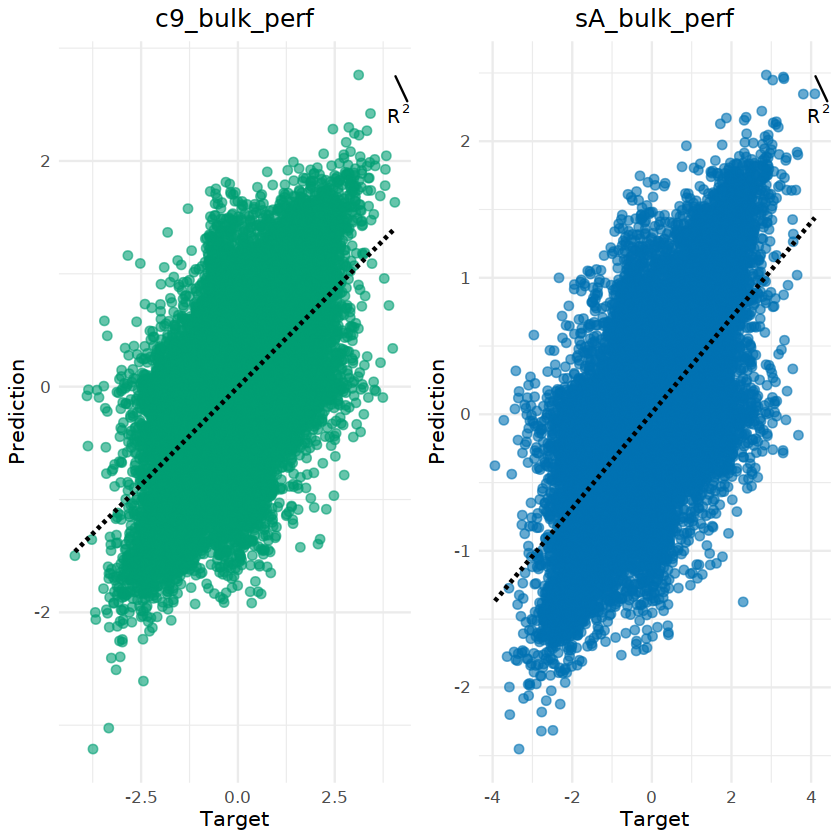

In [4]:
library(ggplot2)
library(gridExtra)
library(ggpubr)
library(ggrepel)

# Function to improve plot aesthetics
improve_plot <- function(df, title, color) {
  p <- ggplot(df, aes(x = target, y = pred)) +
    geom_point(color = color, alpha = 0.6, size = 2) +
    geom_smooth(method = lm, col = "black", linetype = "dashed", se = FALSE) +
    stat_cor(method = "pearson", aes(label = paste(..rr.label.., ..p.label.., sep = "~`,`~")), 
             label.x.npc = "right", label.y.npc = "top", geom = "text_repel") +
    labs(title = title, x = "Target", y = "Prediction") +
    theme_minimal() +
    theme(text = element_text(size=12),
          plot.title = element_text(hjust = 0.5))
  return(p)
}

# Create plots for each dataframe
p1 <- improve_plot(c9_bulk_perf, "c9_bulk_perf", "#009E73")
p2 <- improve_plot(sA_bulk_perf, "sA_bulk_perf", "#0072B2")

# Combine the plots
grid.arrange(p1, p2, ncol = 2)


`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



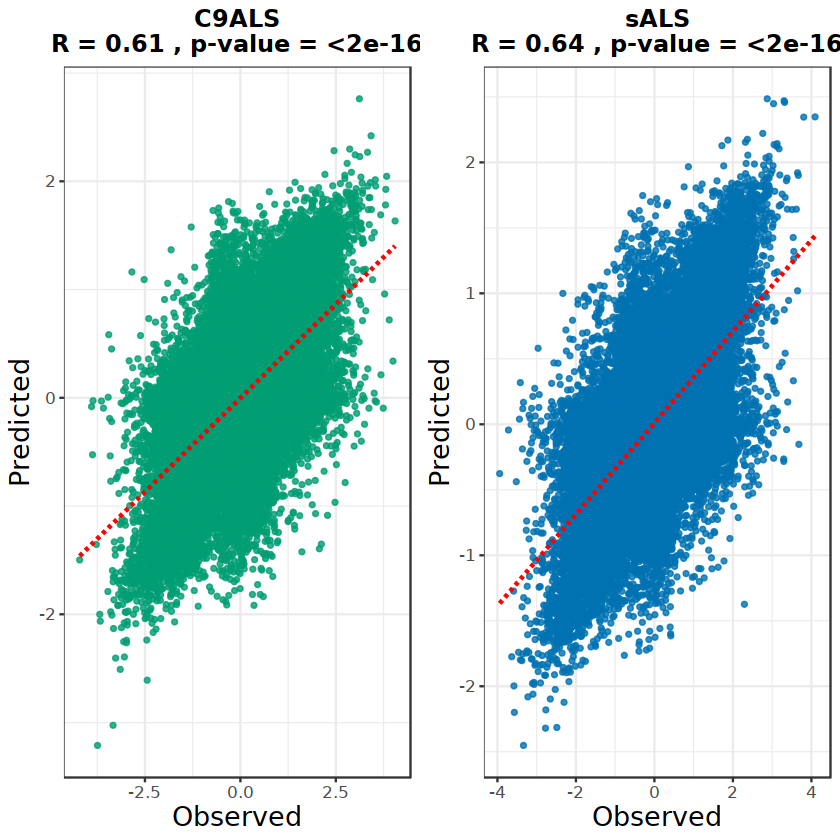

In [22]:
library(ggplot2)
library(gridExtra)
library(ggpubr)
library(ggrepel)

# Function to calculate correlation
calculate_cor <- function(df) {
  cor_res <- cor.test(df$target, df$pred)
  return(paste("R =", round(cor_res$estimate, 2), ", p-value =", format.pval(cor_res$p.value, digits = 2)))
}

# Function to improve plot aesthetics
improve_plot <- function(df, title, color) {
  correlation <- calculate_cor(df)
  p <- ggplot(df, aes(x = target, y = pred)) +
    geom_point(color = color, alpha = 0.8, size = 1) +
    geom_smooth(method = lm, col = "red", linetype = "dashed", se = FALSE) +
    # add \n between title and correlation to get a new line
    labs(title = paste0(title, "\n", correlation), x = "Observed", y = "Predicted") +
    theme_bw() +
    theme(
      text = element_text(size = 12),
      plot.title = element_text(size = 14, face = "bold", hjust = 0.5),
      axis.title.x = element_text(size = 16),
      axis.title.y = element_text(size = 16),
      strip.text = element_text(size = 16, face = "bold"),
      legend.title = element_text(size = 12),
      legend.text = element_text(size = 12)
    )
  return(p)
}

# Create plots for each dataframe
p1 <- improve_plot(c9_bulk_perf, "C9ALS", "#009E73")
p2 <- improve_plot(sA_bulk_perf, "sALS", "#0072B2")

# Combine the plots
p_combined <- grid.arrange(p1, p2, ncol = 2)

# Save the plot
ggsave("/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/results/plots/performance_scatter_plot.pdf", p_combined, width = 20, height = 10, dpi = 300)


In [5]:
calculate_cor <- function(df) {
  cor_res <- cor.test(df$target, df$pred)
  return(data.frame(r = round(cor_res$estimate, 2), 
                    p_value = format.pval(cor_res$p.value, digits = 2)))
}

c9_correlations <- c9_CT_perf %>%
  group_by(celltype) %>%
  do(calculate_cor(.))

sA_correlations <- sA_CT_perf %>%
  group_by(celltype) %>%
  do(calculate_cor(.))

# print(c9_correlations)
print(sA_correlations)

# A tibble: 14 × 3
# Groups:   celltype [14]
   celltype             r p_value
   <chr>            <dbl> <chr>  
 1 AST-FB            0.61 9.4e-16
 2 AST-PP            0.62 <2e-16 
 3 Astrocytes        0.62 <2e-16 
 4 Excitatory        0.61 <2e-16 
 5 IN-PV             0.63 <2e-16 
 6 IN-SST            0.71 <2e-16 
 7 IN-VIP            0.49 <2e-16 
 8 Inhibitory        0.67 <2e-16 
 9 L2-3              0.62 <2e-16 
10 L4                0.64 <2e-16 
11 L5-6-CC           0.5  0.1    
12 Microglia         0.61 <2e-16 
13 Oligodendrocytes  0.68 <2e-16 
14 OPC               0.62 <2e-16 


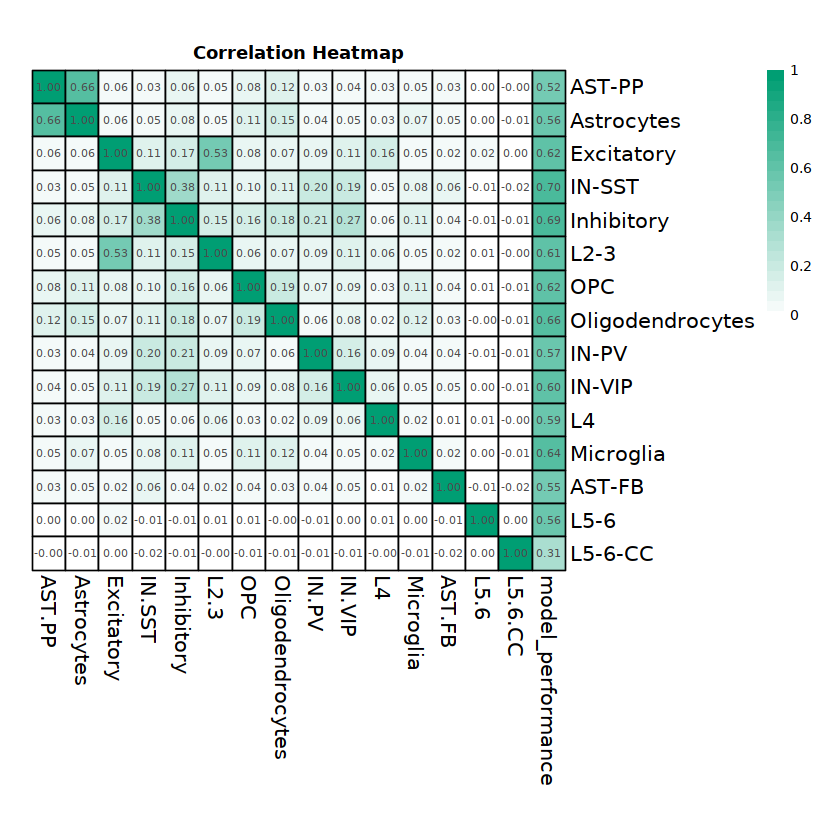

In [53]:
library(dplyr)
library(reshape2)
library(ggplot2)
library(corrplot)
library(pheatmap)


# Assume c9meta and sAmeta are your dataframes
all_celltypes <- c9_meta

# Create a zero matrix
meta_matrix <- matrix(0, nrow = length(unique(all_celltypes$switch_id)), 
                      ncol = length(unique(all_celltypes$celltype)))
rownames(meta_matrix) <- unique(all_celltypes$switch_id)
colnames(meta_matrix) <- unique(all_celltypes$celltype)

# Fill the matrix
for (celltype in unique(all_celltypes$celltype)){
  switch_ids <- all_celltypes[all_celltypes$celltype == celltype, "switch_id"]
  APA_lfc <- all_celltypes[all_celltypes$celltype == celltype, "APA_lfc"]
  meta_matrix[switch_ids, celltype] <- APA_lfc
}

# Convert the matrix to a dataframe
c9meta_df <- as.data.frame(meta_matrix)
corr <- data.frame(cor(c9meta_df, use = "complete.obs"))  # calculate correlations
c9_correlations = data.frame(c9_correlations)


# Extract 'r' column from c9A_correlations
performance <- c9_correlations[['r']]

# Name the vector for accurate matching
names(performance) <- c9_correlations[['celltype']]

# Add 'model_performance' column to corr dataframe
corr$model_performance <- performance[rownames(corr)]


# Define color palette
color <- colorRampPalette(c("white", "#009E73"))(25)

# Use pheatmap to create a heatmap of the correlation matrix without clustering
# Create a heatmap
pheatmap(corr,
         main = "Correlation Heatmap",
         fontsize = 8, # Adjust as needed
         fontsize_row = 12, # Adjust as needed
         fontsize_col = 12, # Adjust as needed
         cluster_rows = FALSE,
         cluster_cols = FALSE,
         color = color,
         border_color = "black",
         cellwidth = 20, # Adjust as needed
         cellheight = 20, # Adjust as needed
         margin = c(5, 10), # Adjust as needed
         display_numbers = TRUE, # To display the correlation coefficients
         number_format = "%.2f" # To format the displayed numbers
)



In [6]:
library(dplyr)
library(reshape2)
library(ggplot2)
library(corrplot)
library(pheatmap)
library(gridExtra)

# Function to prepare the data
prepare_data <- function(meta_data, correlation_data){
  all_celltypes <- meta_data
  main_celltypes = c('Excitatory', 'Inhibitory', 'Oligodendrocytes', 'Astrocytes', 'Microglia', 'OPC')

  # Remove celltypes that are not in the main_celltypes list
  all_celltypes <- all_celltypes[all_celltypes$celltype %in% main_celltypes, ]
  # Create a zero matrix
  meta_matrix <- matrix(0, nrow = length(unique(all_celltypes$switch_id)), 
                        ncol = length(unique(all_celltypes$celltype)))
  rownames(meta_matrix) <- unique(all_celltypes$switch_id)
  colnames(meta_matrix) <- unique(all_celltypes$celltype)
  
  # Fill the matrix
  for (celltype in unique(all_celltypes$celltype)){
    switch_ids <- all_celltypes[all_celltypes$celltype == celltype, "switch_id"]
    APA_lfc <- all_celltypes[all_celltypes$celltype == celltype, "APA_lfc"]
    meta_matrix[switch_ids, celltype] <- APA_lfc
  }
  
  # Convert the matrix to a dataframe
  meta_df <- as.data.frame(meta_matrix)
  corr <- data.frame(cor(meta_df, use = "complete.obs"))  # calculate correlations
  
  # Extract 'r' column from correlations
  performance <- correlation_data[['r']]
  
  # Name the vector for accurate matching
  names(performance) <- correlation_data[['celltype']]
  
  # Add 'model_performance' column to corr dataframe
  corr$model_performance <- performance[rownames(corr)]
  
  return(corr)
}

# Prepare data for c9 and sA
c9_corr <- prepare_data(c9_meta, c9_correlations)
sA_corr <- prepare_data(sA_meta, sA_correlations)

# Define color palette
color <- colorRampPalette(c("white", "#009E73"))(25)

# Create heatmaps for both datasets
c9_heatmap <- pheatmap(c9_corr,
                      main = "C9ALS APA correlation and model performance",
                      fontsize = 8, # Adjust as needed
                      fontsize_row = 12, # Adjust as needed
                      fontsize_col = 12, # Adjust as needed
                      cluster_rows = FALSE,
                      cluster_cols = FALSE,
                      color = color,
                      border_color = "black",
                      cellwidth = 20, # Adjust as needed
                      cellheight = 20, # Adjust as needed
                      margin = c(5, 10), # Adjust as needed
                      display_numbers = TRUE, # To display the correlation coefficients
                      number_format = "%.2f", # To format the displayed numbers
                      silent = TRUE # Do not print output
)
sA_color = colorRampPalette(c("white", "#0072B2"))(25) 
sA_heatmap <- pheatmap(sA_corr,
                       main = "sALS",
                       fontsize = 8, # Adjust as needed
                       fontsize_row = 12, # Adjust as needed
                       fontsize_col = 12, # Adjust as needed
                       cluster_rows = FALSE,
                       cluster_cols = FALSE,
                       color = sA_color,
                       border_color = "black",
                       cellwidth = 20, # Adjust as needed
                       cellheight = 20, # Adjust as needed
                       margin = c(5, 10), # Adjust as needed
                       display_numbers = TRUE, # To display the correlation coefficients
                       number_format = "%.2f", # To format the displayed numbers
                       silent = TRUE # Do not print output

)


In [12]:
# plot options for R
options(repr.plot.width=4, repr.plot.height=4)

In [16]:
# save c9_corr and sA_corr dataframes as csv, remember its R
class(c9_corr)

[1] "data.frame"

In [17]:
write.csv(c9_corr, "c9_corr.csv")
write.csv(sA_corr, "sA_corr.csv")

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

c9_corr = pd.read_csv('c9_corr.csv', index_col=0)
sA_corr = pd.read_csv('sA_corr.csv', index_col=0)

c9_color = sns.light_palette("#009E73", as_cmap=True)
sA_color = sns.light_palette("#0072B2", as_cmap=True)

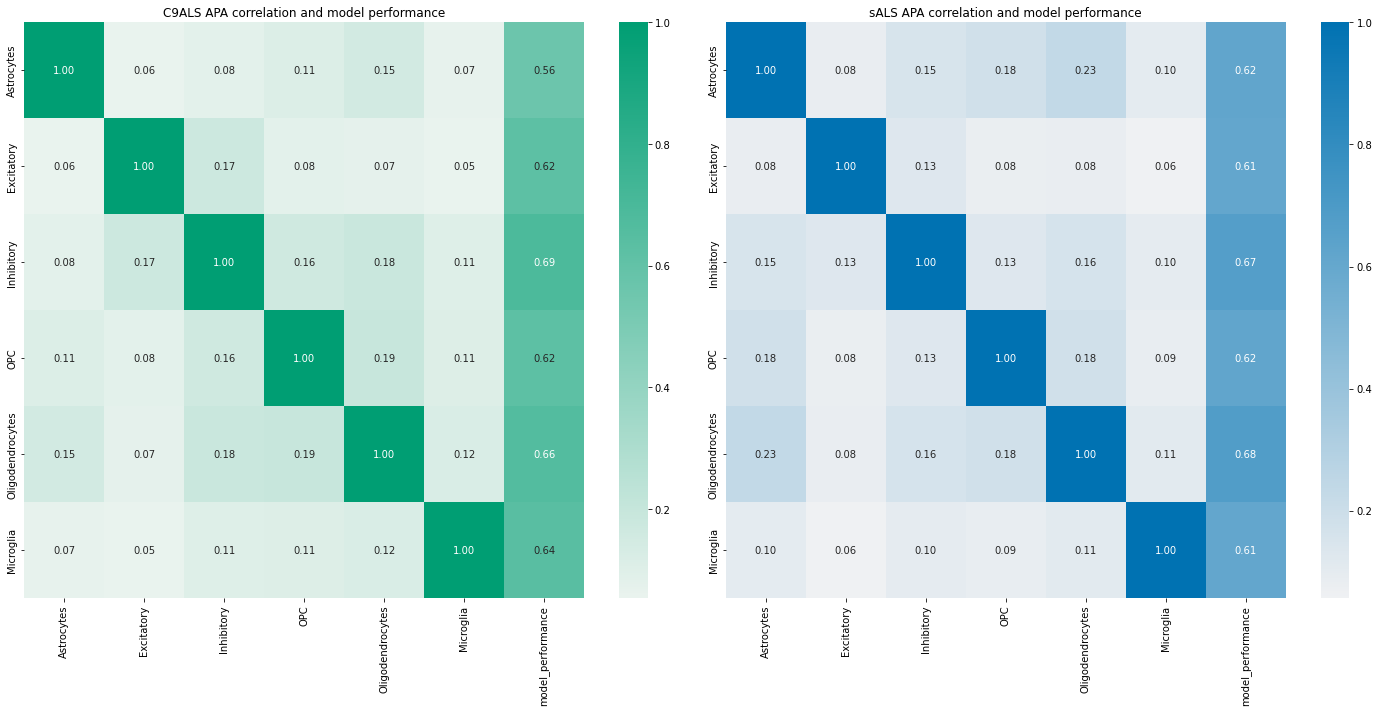

In [2]:
fig, axs = plt.subplots(ncols=2, figsize=(20,10)) # Create a subplot with 2 columns

sns.heatmap(c9_corr, annot=True, fmt='.2f', cmap=c9_color, ax=axs[0]) # Plot on the first subplot
axs[0].set_title('C9ALS APA correlation and model performance')

sns.heatmap(sA_corr, annot=True, fmt='.2f', cmap=sA_color, ax=axs[1]) # Plot on the second subplot
axs[1].set_title('sALS APA correlation and model performance')

plt.tight_layout() # Ensures that the subplots do not overlap
plt.show()

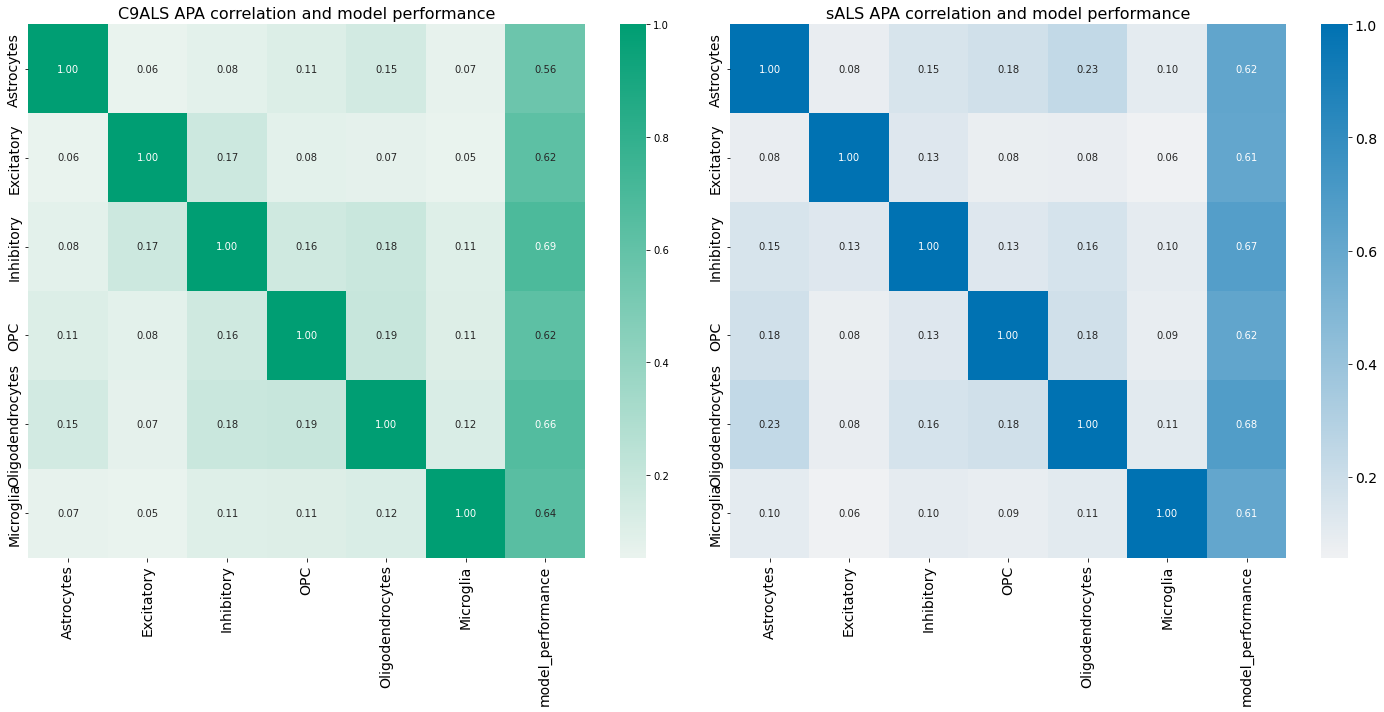

In [18]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,10))

# create a heatmap for each correlation matrix
sns.heatmap(c9_corr, annot=True, fmt='.2f', cmap=c9_color, ax=ax1)
sns.heatmap(sA_corr, annot=True, fmt='.2f', cmap=sA_color, ax=ax2)

# set a title for each subplot
ax1.set_title('C9ALS APA correlation and model performance', fontsize=16)
ax2.set_title('sALS APA correlation and model performance', fontsize=16)

# increase the font size of the color bar and the axes labels
cbar_ax = fig.axes[-1]
cbar_ax.tick_params(labelsize=14)

plt.setp(ax1.get_xticklabels(), fontsize=14)
plt.setp(ax1.get_yticklabels(), fontsize=14)
plt.setp(ax2.get_xticklabels(), fontsize=14)
plt.setp(ax2.get_yticklabels(), fontsize=14)

# display the plot
plt.tight_layout()
# save in pdf and high resolution
plt.savefig('/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/results/plots/APA_corr_and_model_performance.pdf', dpi=300)

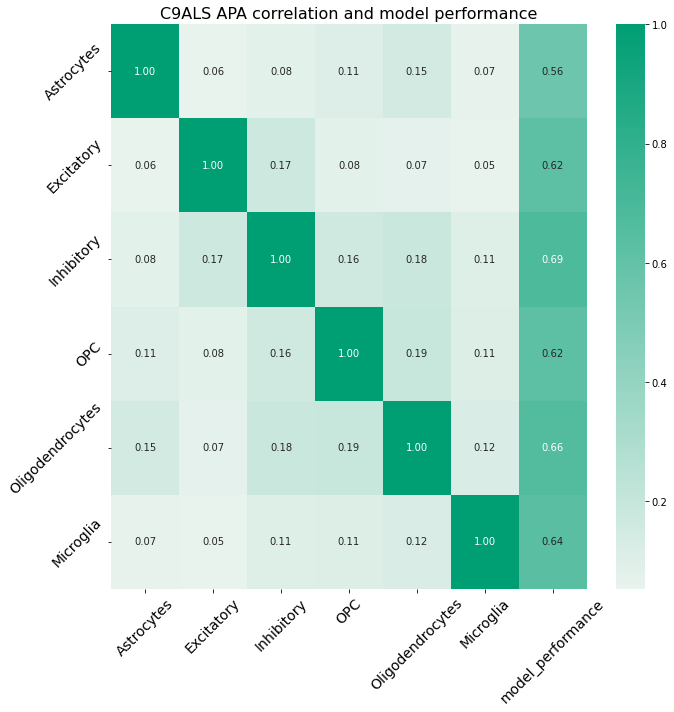

<Figure size 432x288 with 0 Axes>

In [11]:
fig, ax1 = plt.subplots(ncols=1, figsize=(10,10))
sns.heatmap(c9_corr, annot=True, fmt='.2f', cmap=c9_color, ax=ax1)
ax1.set_title('C9ALS APA correlation and model performance', fontsize=16)
cbar_ax = fig.axes[-1]
plt.setp(ax1.get_xticklabels(), fontsize=14, rotation=45)
plt.setp(ax1.get_yticklabels(), fontsize=14, rotation=45)
plt.tight_layout()
plt.show()
plt.savefig('/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/results/plots/C9ALS_APA_corr_and_model_performance.pdf', dpi=300)

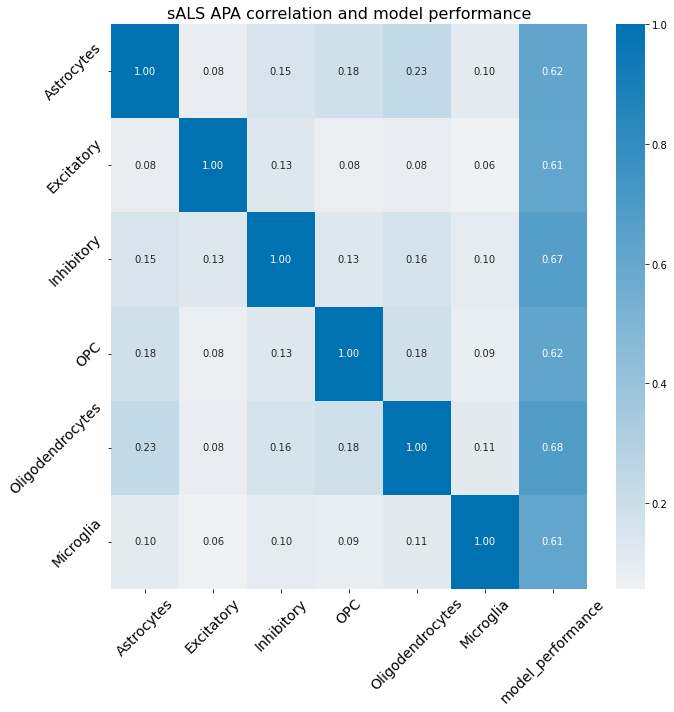

<Figure size 432x288 with 0 Axes>

In [10]:
fig, ax1 = plt.subplots(ncols=1, figsize=(10,10))
sns.heatmap(sA_corr, annot=True, fmt='.2f', cmap=sA_color, ax=ax1)
ax1.set_title('sALS APA correlation and model performance', fontsize=16)
cbar_ax = fig.axes[-1]
plt.setp(ax1.get_xticklabels(), fontsize=14, rotation=45)
plt.setp(ax1.get_yticklabels(), fontsize=14, rotation=45)
plt.tight_layout()
plt.show()
plt.savefig('/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/results/plots/sALS_APA_corr_and_model_performance.pdf', dpi=300)